#  Revenue Driver Regression Model and Price Sensitivity Analysis

### Table of Contents

1. [Exploratory Data Analysis (EDA)](#exploratory-data-analysis-eda)
2. [Model Development](#model-development)
   - 2.1 [OLS Model Summary](#ols-model-summary)
   - 2.2 [Scikit-learn: Estimating Category, Pricing, and Volume Effects on Revenue](#scikit-learn-estimating-category-pricing-and-volume-effects-on-revenue)
3. [Model Interpretation with Business Context](#model-interpretation-with-business-context)
4. [Own Conclusion about model understanding](#own-conclusion-about-model-understanding)

#### Project Overview
**Goal:** Use transaction-level data to define Revenue as the target and identify relevant independent variables.
* **1.** Perform statistical inference using statsmodels OLS to understand variable significance, direction, and impact on revenue.
* **2.** Select and refine features based on statistical and business relevance.
* **3.** Build a regression model using scikit-learn to estimate revenue for unseen transactions.
* **4.** Evaluate performance using R² and error metrics and interpret results for business decisions.

In [2]:
# Operatinal libraries
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Libraries
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.api import OLS
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


# Exploratory Data Analysis (EDA)
Since the dataset is already cleaned and preprocessed, we can directly move to the next step of EDA and feature selection.

In [3]:
data = pd.read_csv('Cleaned_sales_data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22049 entries, 0 to 22048
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Order_ID                  22049 non-null  object 
 1   Customer_ID               22049 non-null  object 
 2   Date                      22049 non-null  object 
 3   Age                       22049 non-null  int64  
 4   Gender                    22049 non-null  object 
 5   City                      22049 non-null  object 
 6   Product_Category          22049 non-null  object 
 7   Unit_Price                22049 non-null  float64
 8   Quantity                  22049 non-null  int64  
 9   Discount_Amount           22049 non-null  float64
 10  Total_Amount              22049 non-null  float64
 11  Payment_Method            22049 non-null  object 
 12  Device_Type               22049 non-null  object 
 13  Session_Duration_Minutes  22049 non-null  int64  
 14  Pages_

In [4]:
# Convert 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Rename 'Total_Amount' to 'Revenue for better clarity'
data = data.rename(columns={'Total_Amount': 'Revenue'})

In [5]:
data.describe()

,Date,Age,Unit_Price,Quantity,Discount_Amount,Revenue,Session_Duration_Minutes,Pages_Viewed,Delivery_Time_Days,Customer_Rating
count,22049,22049.000000,22049.000000,22049.000000,22049.000000,22049.000000,22049.000000,22049.000000,22049.000000,22049.000000
mean,2023-08-15 08:44:45.509547008,34.965441,449.700508,2.831920,59.598256,1210.694234,14.544197,8.998821,6.502109,3.900177
min,2023-01-01 00:00:00,18.000000,5.050000,1.000000,0.000000,6.210000,1.000000,1.000000,1.000000,1.000000
25%,2023-04-27 00:00:00,27.000000,74.050000,1.000000,0.000000,159.800000,12.000000,7.000000,4.000000,3.000000
50%,2023-08-16 00:00:00,35.000000,177.110000,3.000000,0.000000,429.920000,14.000000,9.000000,6.000000,4.000000
75%,2023-12-06 00:00:00,42.000000,499.360000,4.000000,25.080000,1199.060000,17.000000,11.000000,8.000000,5.000000
max,2024-03-26 00:00:00,75.000000,7900.010000,5.000000,6538.290000,37852.050000,73.000000,24.000000,25.000000,5.000000
std,NaN,11.054313,720.091114,1.451207,216.621317,2265.755590,4.862567,2.394224,3.483322,1.128719


In [6]:
# Revenue Analysis by Product Category
product_category = (
    data
    .groupby('Product_Category')
    .agg({
        'Quantity': 'sum',
        'Discount_Amount': 'sum',
        'Revenue': 'sum',
        'Unit_Price': 'mean'
})
    .sort_values(by='Revenue', ascending=False)
    )
product_category


,Quantity,Discount_Amount,Revenue,Unit_Price
Product_Category,,,,
Electronics,7656,630372.73,12810704.46,1761.945563
Home & Garden,7508,248609.45,4932252.80,689.631966
Sports,8375,195583.45,3959650.55,496.231592
Fashion,7489,91407.49,1952250.63,276.721714
Toys,7671,58762.21,1237380.01,169.036781
Beauty,7988,43052.83,851021.76,112.020007
Food,7736,26211.53,518193.32,71.173861
Books,8018,20082.25,433143.63,55.900418


In [7]:
product_category['Revenue_Contribution'] = (
    product_category['Revenue'] / product_category['Revenue'].sum()
)

product_category['Discount_percentage'] =(
    product_category['Discount_Amount'] / product_category['Revenue']
)*100



formated_pc = (
    product_category
    .style
    .format({'Discount_Amount':'${:.0f}', 'Revenue':'${:.0f}', 'Unit_Price': '${:.0f}', 'Revenue_Contribution': '{:.2%}'})
    .background_gradient()
)

formated_pc


,Quantity,Discount_Amount,Revenue,Unit_Price,Revenue_Contribution,Discount_percentage
Product_Category,,,,,,
Electronics,7656,$630373,$12810704,$1762,47.99%,4.920672
Home & Garden,7508,$248609,$4932253,$690,18.48%,5.040485
Sports,8375,$195583,$3959651,$496,14.83%,4.939412
Fashion,7489,$91407,$1952251,$277,7.31%,4.682160
Toys,7671,$58762,$1237380,$169,4.64%,4.748922
Beauty,7988,$43053,$851022,$112,3.19%,5.058958
Food,7736,$26212,$518193,$71,1.94%,5.058253
Books,8018,$20082,$433144,$56,1.62%,4.636395


```JSON
## Category Insights
1. Based on the category of the product, we can see that Electronics, Home & Garden, Sports products are almost than 80% of total revenue contribution
2. Other Products like Fashion, Toys, Beauty, Food and Books are contributing less than 20% of total revenue but they are contributing more quantity sold
3. we can focus on the top 3 categories which are contributing more than 80% of total revenue and also we can consider other categories as well for
better prediction

In [8]:
sales = data[['Unit_Price', 'Discount_Amount', 'Revenue']]

#### Pairplot Analysis

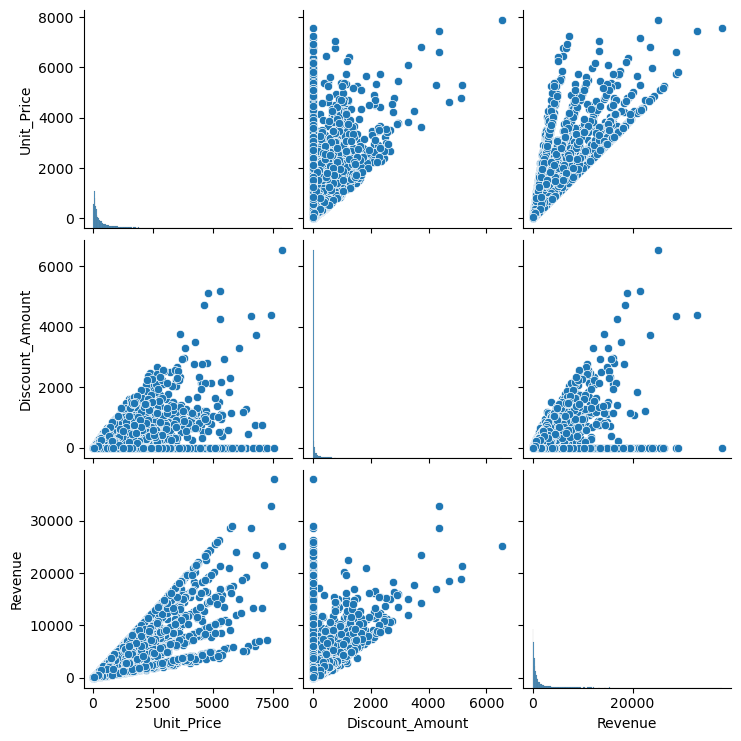

In [9]:
sns.pairplot(sales)

```JSON
## Plot interpretation
Based on the observation from this plot, the data represents category-level transactions rather than item-level pricing. Since unit price varies over time within the same category due to changing product mix, no clear global relationship between the plotted variables is visible.
```

#### Plot of Key Feature for EDA

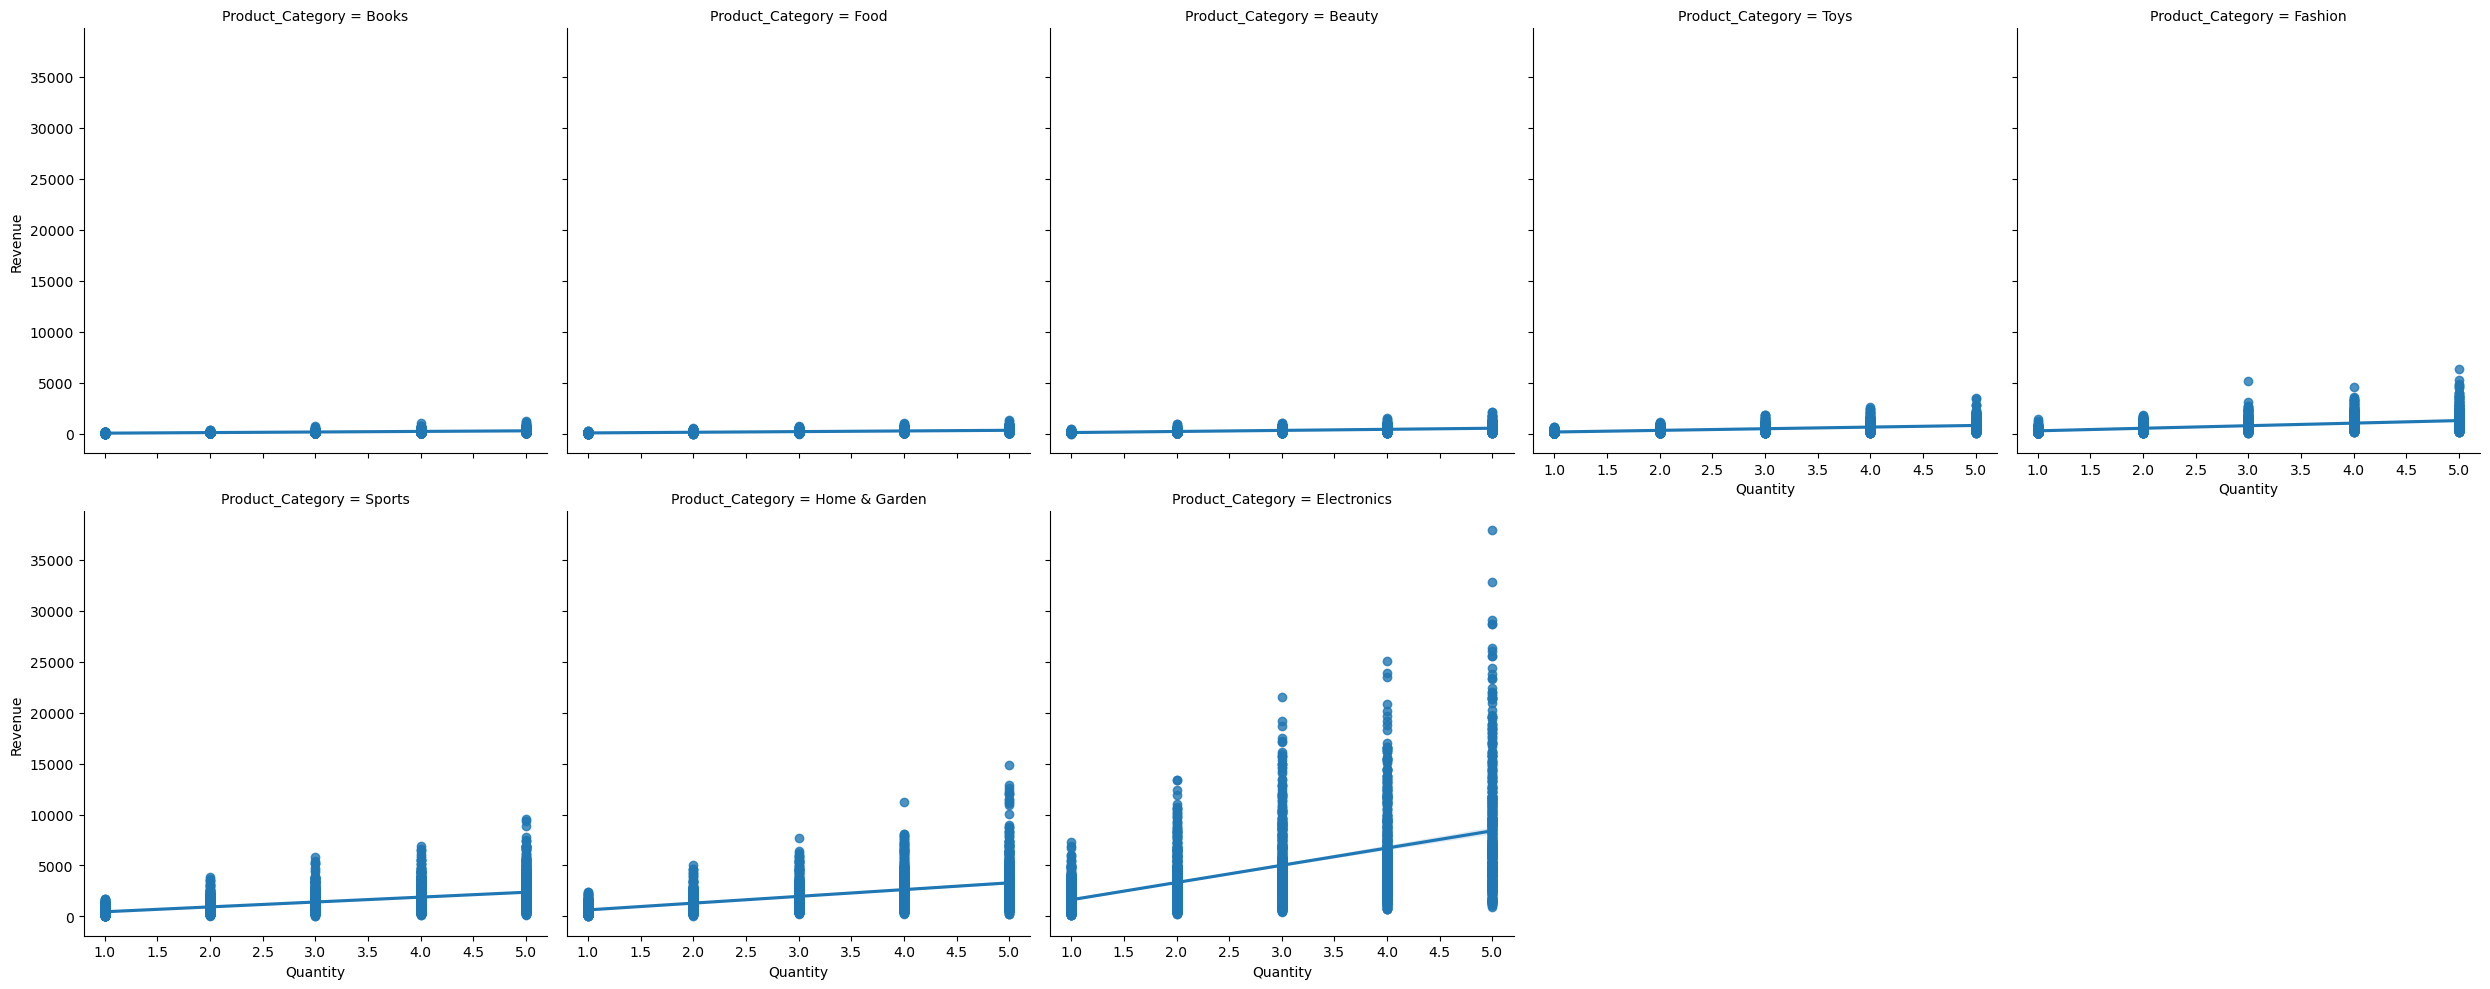

In [10]:

sns.lmplot(
    data=data,
    x='Quantity',
    y='Revenue',
    col='Product_Category',
    col_wrap=5,
)
plt.show()

```JSON
# Plot interpretation
The plot shows a positive correlation between quantity sold and revenue, which is expected but since most quantity values are between 1-5, the relationship is not very strong.
but we can see feature importance when we run in OLS regression model. Individually this feature may not show strong correlation but when combined with other features it may show significant impact on revenue Estimattion. 

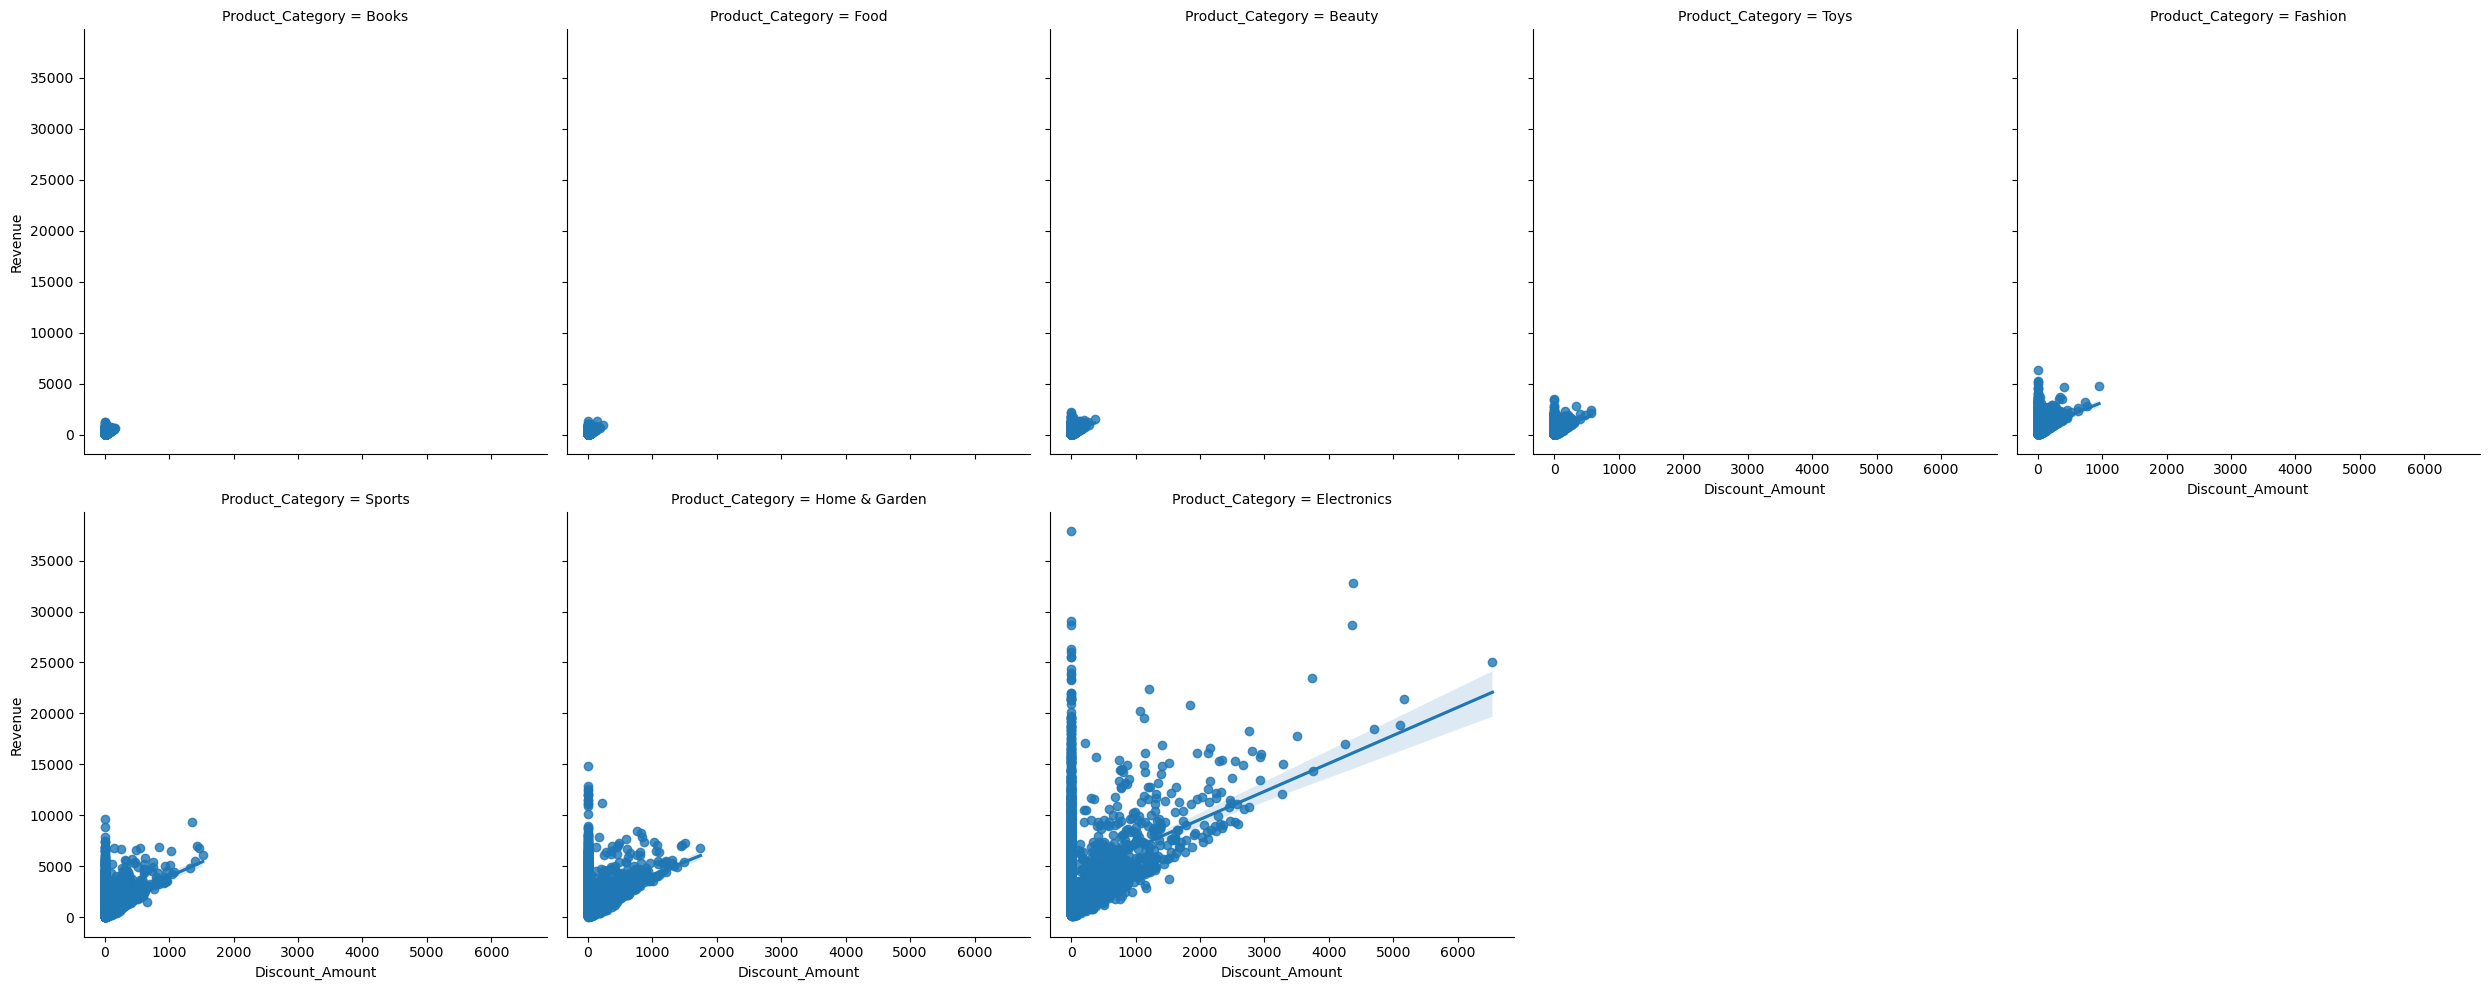

In [11]:
sns.lmplot(
    data=data,
    x='Discount_Amount',
    y='Revenue',
    col='Product_Category',
    col_wrap=5,
)
plt.show()

````JSON
## Plot Interpretation
Discount amount shows a positive association with quantity, where higher quantities are often observed alongside higher discount amounts. This pattern is expected because discount amount increases with promotional intensity and transaction value, and does not necessarily imply that discounts directly cause higher demand. this relationship should be interpreted as an association rather than a causal effect on quantity.


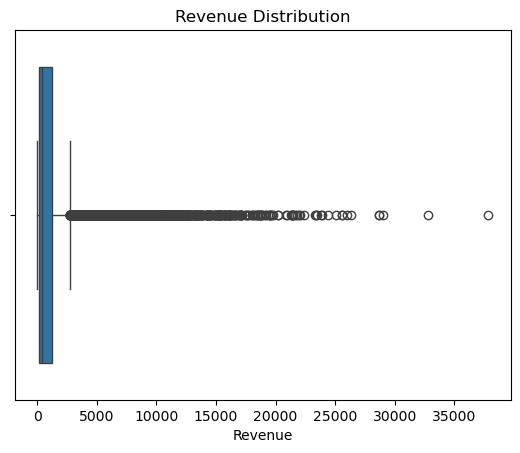

In [12]:
fig = sns.boxplot(
    data=sales['Revenue'],
    orient='h',
    native_scale=True
        )
fig.set_title('Revenue Distribution')
plt.show()

```JSON
## Boxplot of Revenue Distribution

Boxplot of revenue distribution shows that revenue is extremely right skewed and seems like most of the transactions have low revenue values. We can also consider log transformation of revenue to reduce the impact of outliers and improve model performance.

#### Feature Engineering

In [13]:
# Model Features

# Price Tier
data['Price_tier'] = data.groupby('Product_Category')['Unit_Price'].transform(lambda x : pd.qcut(x, q=4, labels=[1, 2, 3, 4]))

# Calculate discount percentage
data['Discount_percentage'] = round(data['Discount_Amount'] / data['Revenue']*100)

# Create a binary variable for whether the product has a discount
data['has_discount'] = (data['Discount_Amount'] > 0).astype(int)

# Create a binary variable for whether the transaction occurred on a weekend
data['is_weekend'] = (data['Date'].dt.weekday >= 5).astype(int)


data.head()

,Order_ID,Customer_ID,Date,Age,Gender,City,Product_Category,Unit_Price,Quantity,Discount_Amount,...,Device_Type,Session_Duration_Minutes,Pages_Viewed,Is_Returning_Customer,Delivery_Time_Days,Customer_Rating,Price_tier,Discount_percentage,has_discount,is_weekend
0,ORD_000902,CUST_00902,2024-03-26,30,Female,Konya,Books,84.30,4,21.72,...,Desktop,8,9,True,5,5,4,7.0,1,0
1,ORD_003209,CUST_03209,2024-03-26,45,Male,Izmir,Food,50.69,1,11.72,...,Desktop,5,6,False,2,1,2,30.0,1,0
2,ORD_001404,CUST_01404,2024-03-26,43,Male,Adana,Beauty,120.67,2,7.88,...,Desktop,10,8,True,4,5,3,3.0,1,0
3,ORD_000463,CUST_00463,2024-03-26,26,Male,Istanbul,Food,19.84,3,0.00,...,Mobile,11,10,False,6,4,1,0.0,0,0
4,ORD_002934,CUST_02934,2024-03-26,46,Male,Ankara,Toys,60.12,2,12.95,...,Tablet,22,7,True,6,4,1,12.0,1,0


In [14]:
# Export the FE data to a new CSV file
data.to_csv('FE_sales_data.csv', index=False)

# Model Development
Given Datasets key features are: Product_Category, Quantity ,has_discount, is_weekend, Is_Returning_Customer, Price_tier
These Factors are important for revenue because they capture key aspects of purchasing patterns that influence revenue generation.

In [15]:
revenue_data = data[['Revenue','Product_Category', 'Quantity', 'has_discount', 'is_weekend', 'Is_Returning_Customer', 'Price_tier']]

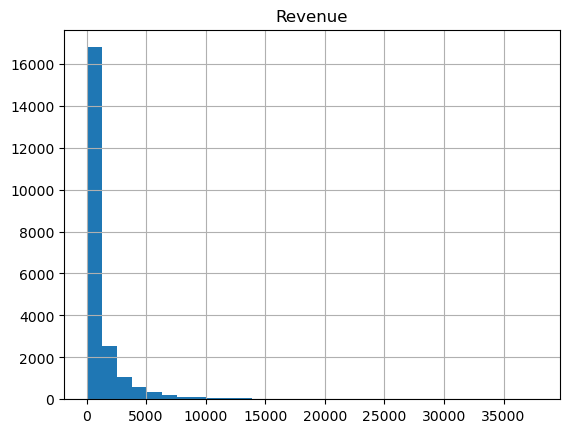

In [16]:
revenue_data[['Revenue']].hist(
    bins=30,
)
plt.show()

#### Histogram

**Plot Interpretation**
1. The Revenue shows a right skewed distribution, which indicates that high revenue transactions are less frequent than low revenue transactions.

<Axes: >

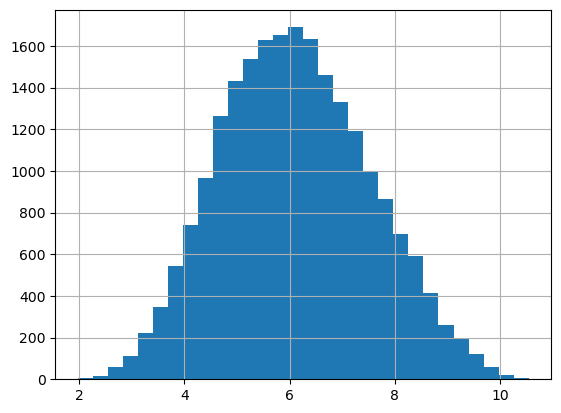

In [17]:
# Log for skewed Data
log = np.log1p(revenue_data['Revenue'])
log.hist(bins=30)



In [18]:
# Encoding Categorical Variables

revenue_data = pd.get_dummies(
    revenue_data, 
    columns=['Is_Returning_Customer', 'Product_Category'], 
    drop_first=True
).astype(int)

revenue_data = revenue_data.rename(columns={'Product_Category_Home & Garden': 'Product_Category_Home_Garden'})



In [19]:
revenue_data.head()

,Revenue,Quantity,has_discount,is_weekend,Price_tier,Is_Returning_Customer_True,Product_Category_Books,Product_Category_Electronics,Product_Category_Fashion,Product_Category_Food,Product_Category_Home_Garden,Product_Category_Sports,Product_Category_Toys
0,315,4,1,0,4,1,1,0,0,0,0,0,0
1,38,1,1,0,2,0,0,0,0,1,0,0,0
2,233,2,1,0,3,1,0,0,0,0,0,0,0
3,59,3,0,0,1,0,0,0,0,1,0,0,0
4,107,2,1,0,1,1,0,0,0,0,0,0,1


In [20]:
# Feature and Target Variable
x = revenue_data.drop(columns=['Revenue'])
y = log


In [21]:
# Train-Test Split

xtrain, xtest, ytrain, ytest = train_test_split(
    x,
    y,
    test_size=0.3,
    random_state=42
)

#### Model Construction

In [22]:
#Ols Formula

ols_formula = 'Revenue ~ Quantity + Price_tier + has_discount + Is_Returning_Customer_True + Product_Category_Books + Product_Category_Electronics + Product_Category_Fashion + Product_Category_Food + Product_Category_Home_Garden + Product_Category_Sports + Product_Category_Toys'

In [23]:
ols_data = pd.concat([xtrain, ytrain], axis=1)

# OLS Model
model = smf.ols(formula = ols_formula, data = ols_data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Revenue   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                 3.389e+04
Date:                Tue, 17 Feb 2026   Prob (F-statistic):               0.00
Time:                        16:19:58   Log-Likelihood:                -2303.8
No. Observations:               15434   AIC:                             4632.
Df Residuals:                   15422   BIC:                             4723.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        2.8637      0.010    275.101      0.000       2.843       2.884
Quantity                         0.4057      0.002    259.767      0.000       0.403       0.409
Price_tier                       0.5582      0.002    276.255      0.000       0.554       0.562
has_discount                    -0.1422      0.005    -30.297      0.000      -0.151      -0.133
Is_Returning_Customer_True       0.0142      0.006      2.409      0.016       0.003       0.026
Product_Category_Books          -0.6821      0.009    -76.516      0.000      -0.700      -0.665
Product_Category_Electronics     2.6874      0.009    297.037      0.000       2.670       2.705
Product_Category_Fashion         0.8802      0.009     97.161      0.000       0.862       0.898
Product_Category_Food           -0.4774      0.009    -52.925      0.000      -0.495      -0.460
Product_Category_Home_Garden     1.7735      0.009    196.367      0.000       1.756       1.791
Product_Category_Sports          1.4471      0.009    163.810      0.000       1.430       1.464
Product_Category_Toys            0.3747      0.009     41.423      0.000       0.357       0.392
==============================================================================
Omnibus:                     1485.578   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3239.844
Skew:                          -0.608   Prob(JB):                         0.00
Kurtosis:                       4.886   Cond. No.                         35.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### OLS Model Summary


The $R^2$ and Adjusted $R^2$ of 0.960 indicate the model explains ~96.0% of the variance in Revenue, representing an exceptional fit.

All features are statistically significant with p-values < 0.05, indicating a statistically significant association with revenue.

Electronics and Home & Garden show the strongest positive relative contribution to revenue, while Books and Food show significantly lower contribution compared to the baseline category.

#### Variance inflation factor (VIF)

In [24]:
# VIF Calculation

X_const = add_constant(xtrain)

vif_data = pd.DataFrame()
vif_data['Features'] = X_const.columns
vif_data['VIF'] = [
    variance_inflation_factor(X_const.values, i)
    for i in range(X_const.shape[1])
]

vif_data

,Features,VIF
0,const,21.563333
1,Quantity,1.005758
2,has_discount,1.000974
3,is_weekend,1.000541
4,Price_tier,1.000658
5,Is_Returning_Customer_True,1.005090
6,Product_Category_Books,1.742158
7,Product_Category_Electronics,1.706506
8,Product_Category_Fashion,1.703943
9,Product_Category_Food,1.713580


#### Scikit-learn: Estimating Category, Pricing, and Volume Effects on Revenue

In [25]:
# Multiple Linear Regression Model

mlr = LinearRegression()
mlr.fit(xtrain, ytrain)

y_pred = mlr.predict(xtest)

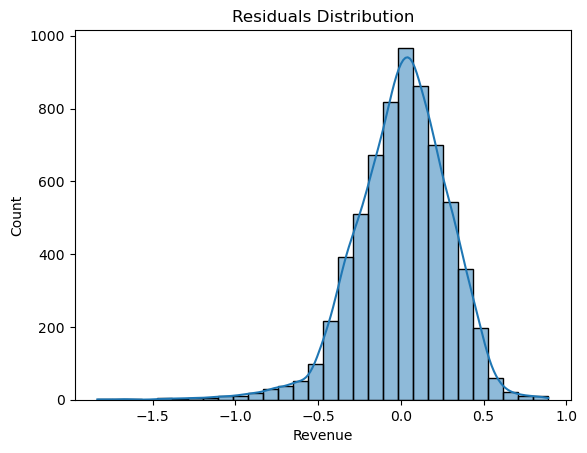

In [26]:
# Residual Calculation

residual = ytest - y_pred
sns.histplot(residual, bins=30, kde=True)
plt.title('Residuals Distribution')
plt.show()

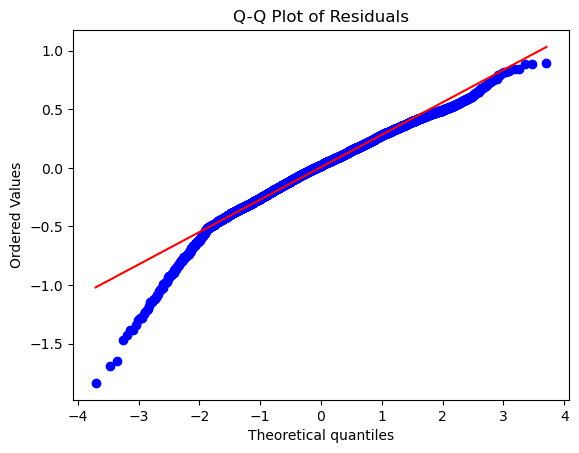

In [27]:
# Q-Q Plot for Residuals

stats.probplot(residual, plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

#### Residual vs Predicted Plot
The residuals are randomly scattered around zero across the range of predicted values, indicating that the model captures the underlying relationship
well

Text(0.5, 1.0, 'Residuals vs Predicted Values')

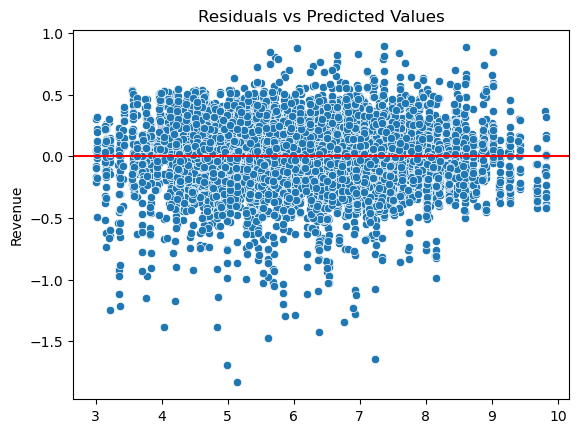

In [28]:
# Residuals vs Predicted Values

fig = sns.scatterplot(x=y_pred, y=residual)
fig.axhline(0, color='red')
fig.set_title('Residuals vs Predicted Values')

In [29]:
# Metrics Calculation

print('Mean Absolute Error:', mean_absolute_error(ytest, y_pred))
print('Mean Squared Error:', mean_squared_error(ytest, y_pred))
print('R-squared:', r2_score(ytest, y_pred))

Mean Absolute Error: 0.21564046372864576
Mean Squared Error: 0.07839848143917327
R-squared: 0.9608798587560274


In [30]:

coefficients = pd.DataFrame({
    'Features': xtrain.columns,
    'Coefficient': mlr.coef_,
})

coefficients.sort_values(by='Coefficient', ascending=False).reset_index(drop=True)

,Features,Coefficient
0,Product_Category_Electronics,2.687502
1,Product_Category_Home_Garden,1.773514
2,Product_Category_Sports,1.447174
3,Product_Category_Fashion,0.880309
4,Price_tier,0.558157
5,Quantity,0.405717
6,Product_Category_Toys,0.374752
7,Is_Returning_Customer_True,0.014257
8,is_weekend,-0.005748
9,has_discount,-0.142221


#### Plot of Features Coefficients

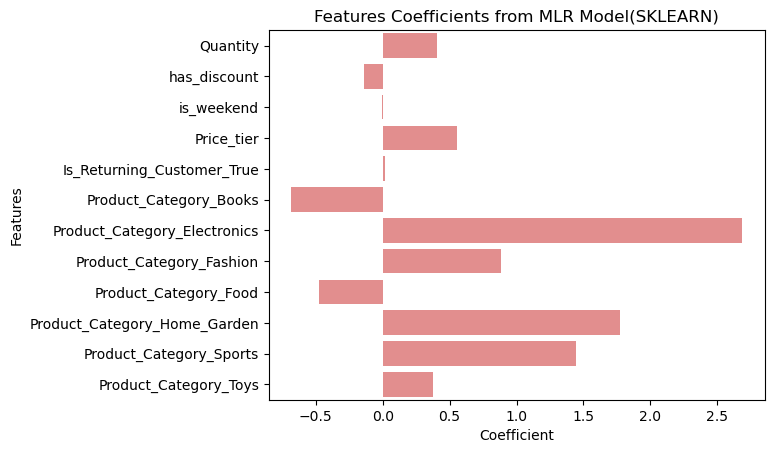

In [31]:
# Features Coefficients from MLR Model(SKLEARN)

fig =sns.barplot(
    data=coefficients,
    x='Coefficient',
    y='Features',
    orient='h',
    color='lightcoral',
)
fig.set_title('Features Coefficients from MLR Model(SKLEARN)')
plt.show()

#### Plot of Actual revenue vs Predicted revenue
The Plot of Actual vs Predicted revenue shows that the predicted values closely follow the actual values with indicating model is good in capturing the underlying relationship between selected features and revenue. 

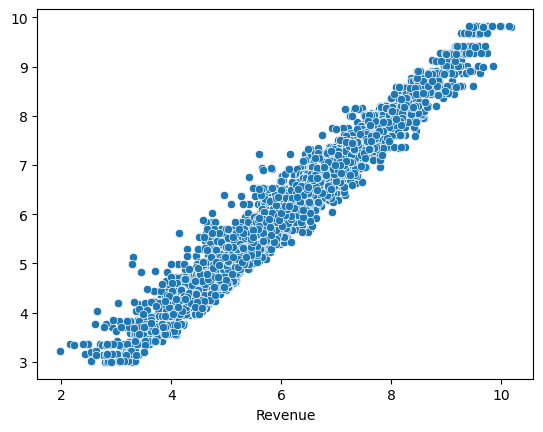

In [32]:
# Actual Revenue vs Estimated Revenue
sns.scatterplot(x=ytest, y=y_pred)
plt.show()

In [33]:
# Cross Validation Predictions

train_pred = mlr.predict(xtrain)
test_pred = mlr.predict(xtest)

In [34]:
# Metrics Table for Train and Test data

metrics = {
    'R2': [r2_score(ytrain, train_pred), r2_score(ytest, test_pred)],
    'MAE': [mean_absolute_error(ytrain, train_pred), mean_absolute_error(ytest, test_pred)],
    'MSE': [mean_squared_error(ytrain, train_pred), mean_squared_error(ytest, test_pred)],
    'RMSE': [np.sqrt(mean_squared_error(ytrain, train_pred)), np.sqrt(mean_squared_error(ytest, test_pred))],
    }

metrics_table = pd.DataFrame(metrics, index=['Train', 'Test'])
metrics_table


,R2,MAE,MSE,RMSE
Train,0.960281,0.215454,0.078911,0.280912
Test,0.960880,0.215640,0.078398,0.279997


In [35]:
# Metrics in Original Scale $ -- Unscaling the log transformed predictions and actual values to interpret the metrics in terms of original revenue values.

ytrain_rs = np.expm1(ytrain)
ytest_rs  = np.expm1(ytest)

train_pred_rs = np.expm1(train_pred)
test_pred_rs  = np.expm1(test_pred)

Currency_metrics = {
    'Average_Revenue': [ytrain_rs.mean(), ytest_rs.mean()],
    'MAE': [mean_absolute_error(ytrain_rs, train_pred_rs), mean_absolute_error(ytest_rs, test_pred_rs)],
    'RMSE': [np.sqrt(mean_squared_error(ytrain_rs, train_pred_rs)), np.sqrt(mean_squared_error(ytest_rs, test_pred_rs))]
}

Currency_metrics_metrics_table = pd.DataFrame(
    Currency_metrics,
    index=['Train', 'Test']
)

Currency_metrics_metrics_table.style.format({'Average_Revenue': '${:.2f}', 'MAE': '${:.2f}', 'RMSE': '${:.2f}'})

,Average_Revenue,MAE,RMSE
Train,$1211.55,$250.96,$731.02
Test,$1208.71,$248.10,$642.82


# Model Interpretation with Business Context

#### Model Metrics Interpretation

* **R-squared (R²): 0.960880**
* The model explains approximately 96.09% of the variance in revenue in the test data. The train $R^2$ of 0.960281 (96.0%) is very close to the test value, indicating strong generalization and minimal overfitting.

* **Mean Absolute Error (MAE): 0.21** 
* On average, the model's log-revenue predictions are off by only 0.21 units. As seen in the plot of actual vs Estimated revenue, the model is good at capturing the relationship between features and revenue, which is useful for business planning

* **Mean Squared Error (MSE): 0.07** — The low MSE of both test (0.078398) and train (0.078911) shows the model is stable and is not being distorted by large prediction errors.

#### Model Mertics Interpretation with Business Context

* **Coefficients Interpretation in Business Context:**
    The large coefficients for Electronics (2.687440), Home & Garden (1.773539), and Sports (1.447101) suggest these categories have a strong positive impact on revenue, indicating that focusing on these categories is a key strategy for maximizing revenue.

* **MAE and RMSE Interpretation in Business Context:**
    In Business Scenario, If average revenue per transaction is around **$1208.71**
* **Typical Scenario (MAE):** For a predicted transaction of **$1,208.71**, the average error is **±$248.10**, resulting in a typical range of **$960.61** to **$1,456.81**.
* **High-Risk Scenario (RMSE):** For volatile transactions, the error range is **±$642.82**, creating a risk range of **$565.89** to **$1,851.53**..

### Business Implications

* **Strategic Focus:** Focus on high-revenue categories like Electronics, Home & Garden, and Sports for marketing and inventory strategies, as these show the highest positive coefficients.

* **Discount Optimization:** As shown earlier, the presence of a discount (has_discount) has a negative coefficient, and the dataset is dominated by low-value transactions. We can perform optimization by reducing the frequency of discounts on low-value products and selectively applying a discount flag to premium products; this could increase revenue contribution through higher quantities purchased in top tiers.

* **Fashion Category Growth:** In the Product Categories analyzed, we observed that Fashion has a low percentage discount allocation yet maintains a higher average unit price. Since the Fashion category has a strong positive coefficient, implementing strategies for this category would boost our revenue generation. Currently, we see overall lower discounts; by offering more strategic discounts, we could gain an advantage in revenue generation.

* **Margin Protection:** We observed in the Product Categories that Food and Books have negative coefficients, which means they make less of a contribution to revenue compared to other categories. Even though these two products are sold in higher quantities, reducing discounts here could boost overall revenue.

# Own Conclusion about model understanding

**Data Nature**
* Before building any model, we should understand how the numbers are actually created in the business. If we don’t know how the data is formed, the model may look accurate but still not reflect the real logic behind the numbers.

**Real-World variation and Balance**
* Even if current results look good, real-world outcomes are usually influenced by many visible and hidden factors. Adding more meaningful information helps represent reality better. Using L2 (Ridge) can reduce extreme dependence on a few strong factors and make the model more balanced and stable over time.
